# Error mitigation tutorial

The purpose of this tutorial is to demonstrate the basic use of error mitigation routines of  the QREM package.

In [1]:
from qrem.cn import simulation as cnsimulation 
from qrem.mitigation import mitigation_routines
from qrem.benchmarks import hamiltonians
from qrem.characterization import characterization_routine
from datetime import date
from qrem.providers import simulation as simulate_experiment
from qrem.qtypes.characterization_data import CharacterizationData
from qrem.qtypes.mitigation_data import MitigationData
from qrem.visualisation import benchmark_plots_functions

<a id='Overview'></a>
### List of contents 


1. [Data generation for mitigation routine](#Part1)

    1.1 [Creation and execution of the experiments on simulators/real quantum hardware](#Part1)
    
    1.2. [Execution of the characterization routine](#Characterization)

2. [Mitigation workflow](#Mitigation)

    2.1 [Initial steps](#InitialS)

    2.2 [Error mitigation execution](#MExecution)

    2.3 [Performance analysis](#PAnalysis)

    2.4 [Visualization](#Visualization)





<a id='Part1'></a>

### 1.1.1 Preparation of experiments characterizing readout noise

The first step in experiment preparation is creation of characterization circuits. 
This requires specifying the following parameters: 

1. number_of_qubits - a variable describing number of qubits for which characterization is going to be performed. Note that number_of_qubits is not necessarily equal to the total numbers of qubits in a device, as one may be interested in characterization  only a subset of all qubits. In the example below we set number of qubits to 10

2. experiment_name - a string specifying a typ of readout characterization experiment to be performed. QREM supports two types of characterization experiments Quantum Detector Overlapping Tomography ('QDOT') or Diagonal Detector Overlapping Tomography ('DDOT').  Here we choose 'DDOT'. 

3. Number of characterization circuits: number of circuits used in characterization routine.

4. Number of shots (number of each circuits repetition).

5. include_benchmark_circuits - a bool variable indicating whether the experiment should include circuits that are going to be used in noise model reconstruction and mitigation benchmarks  .

6. number_of_benchmark_circuits - an integer specifying number of circuits used in benchmarks. 


In [2]:
number_of_qubits = 10

experiment_type = "DDOT"

number_of_circuits = 300

number_of_shots = 10**4

include_benchmark_circuits = True

number_of_benchmark_circuits = 20



### 1.1.2 Execution of the experiments on simulators/real quantum hardware

Execution of characterization circuits on quantum backends requires access to quantum hardware. QREM supports backends such as IBM Quantum and AWS Bracket.  Detailed description of circuits implementation on those backends is described in tutorials .

To illustrate functionalities of the package here we simulate a noise characterization experiment according to a CN noise model (see). For simplicity we do not include neighbors.

To specify the noise model one needs to provide number of clusters of given locality:

1. number_of_3_qubit_clusters - number of clusters of locality 3 (consisting of 3 qubits) Here set to 1.

2. number_of_2_qubit_clusters - number of clusters of locality 2 (consisting of 2 qubits) Here set to 3.

3. number_of_1_qubit_clusters - number of clusters of locality 1 (consisting of 3 qubits) Here set to 1.

The noise model is created using cn.simulation module. It returns object of a CNNoiseModel class that stores all properties of the CN nosie model. 



In [3]:
number_of_3_qubit_clusters = 1

number_of_2_qubit_clusters = 3

number_of_1_qubit_clusters = 1

noise_model_simulation=cnsimulation.create_random_noise_model(number_of_qubits=number_of_qubits,clusters_specification=[[3,number_of_3_qubit_clusters], [2, number_of_2_qubit_clusters], [1, number_of_1_qubit_clusters]])



An object of CharacterizationData class is created, which stores all data created during characterization stage, and benchmark circuits corresponding to ground states of local Hamiltonians are created.  


In [4]:
characterization_data_container = CharacterizationData()

characterization_data_container.experiment_type = 'DDOT' 

if include_benchmark_circuits:
    
    hamiltonians_dictionary, circuits_ground_states = hamiltonians.create_hamiltonians_and_ground_states(number_of_qubits=number_of_qubits,number_of_benchmark_circuits=number_of_benchmark_circuits)

Simulation of the noisy experiment is performed using simulate_noisy_experiment function that requires the following parameters:

1. noise_model - an object of CNNoiseModel class, here noise_model_simulation.

2. number_of_circuits - an integer specifying number of circuits used in characterization. Here number_of_circuits set in preparation stage.

3. number_of_shots - an integer specifying number of shots. Here number_of_shots set in preparation stage.

Results of experiment are stored in the characterization_data_container object.

In [5]:
characterization_data_container.results_dictionary = simulate_experiment.simulate_noisy_experiment(noise_model=noise_model_simulation,number_of_circuits=number_of_circuits,number_of_shots=number_of_shots,save_data=True,new_data_format=True,ground_states_circuits=circuits_ground_states,data_directory='').counts

characterization_data_container.ground_states_list  = list(characterization_data_container.results_dictionary.keys())[-number_of_benchmark_circuits:]

10
completeness: True
Adding 290 random circuits to a 10-element set
Set of 300 circuits, completeness: True
noisy results generated in: 13.611753463745117 seconds
Saving pickled file to:  '.'
Saving pickled file to:  '.'


<a id='Characterization'></a>

### Execution of the characterization routine

Execution of the characterization routine is performed. Function execute_characterization_workflow takes as an input experimental data stored in characterization_data_container object. Detailed description of the noise characterization functionalities can be found in tutorial 2 Noise Characterisation 


In [6]:
characterization_data_container= characterization_routine.execute_characterization_workflow(characterization_data_container=characterization_data_container)


MARGINALS COMPUTATION FINISHED


100%|██████████| 55/55 [00:00<00:00, 3250.12it/s]


REDUCED POVMS COMPUTATION FINISHED

Calculating errors of type: ('worst_case', 'classical')


100%|██████████| 10/10 [00:00<00:00, 16723.70it/s]


DONE
POVMS DISTANCES COMPUTATION FINISHED

Calculating correlations of type: ('worst_case', 'classical')


100%|██████████| 45/45 [00:00<00:00, 3199.91it/s]

DONE
PAIRWISE READOUT ERRORS CORRELATION COEFFICIENTS FINISHED

Current max cluster size: 2

Current max cluster size: 3



Current max cluster size: 4



<a id='Mitigation'></a>

### Readout error mitigation 

To demonstrate functionalities of mitigation module 

One of the results of the characterization workflow are reconstructed noise models of different locality. To demonstrate functionalities of mitigation results of error mitigation based on those models are compared to the exact noise model that was used in the simulation of the noisy experiment. 
To this end characterization_data_container is updated to include the exact noise model. This is an optional step and it is not performed when working with data coming from quantum hardware.    



In [7]:
characterization_data_container.noise_model_list.append(noise_model_simulation) 

<a id='InitialS'></a>

### 2.1 Initial steps 

Energy of ground states prepared by the noisy device is estimated  


In [8]:
energy_dictionary= hamiltonians.eigenstate_energy_calculation_and_estimation(characterization_data_container.benchmark_results_dictionary ,  characterization_data_container.benchmark_marginals_dictionary ,hamiltonians_dictionary)


20it [00:00, 2221.09it/s]


An object of MitigationData class is created to store results of mitigation is created


In [9]:
mitigation_data = MitigationData()

<a id='MExecution'></a>

### 2.2 Error mitigation execution

Error mitigation is performed using estimate_mitigated_energy_over_noise_models function of the mitigation module. It performs mitigation for all CN noise models reconstructed during the characterization stage. For each noise model it returns a dictionary with the mitigated values of energies for Hamiltonians used in the benchmark. The corresponding data structure is a dictionary. As an input to the mitigation routine one need to specify:

1. characterization_data- an object of CharacterizationData class storing results of characterization routine and experimental data, here characterization_data_container 

2. hamiltonians_dictionary - dictionary specifying Hamiltonians, for which ground states were implemented, here hamiltonians_dictionary

 

In [10]:

noise_models_mitigation_results_dictionary = mitigation_routines.estimate_mitigated_energy_over_noise_models(characterization_data=characterization_data_container ,hamiltonians_dictionary=hamiltonians_dictionary,return_marginals=True)

     
mitigation_data.noise_models_mitigation_results_dictionary = noise_models_mitigation_results_dictionary   

100%|██████████| 20/20 [00:00<00:00, 246.86it/s]


<a id='PAnalysis'></a>

### 2.4 Performance analysis

To compute errors  of mitigation the exact data is compared to results obtained using error mitigation. Also some statistical features of the errors for different noise models are obtained and printed together with the corresponding clusters structure. The last results correspond to the noise model used in characterization experiment simulation


In [11]:
noise_models_mitigated_energy_dictionary_error = mitigation_routines.compute_mitigation_errors(mitigation_data=mitigation_data,hamiltonian_energy_dictionary=energy_dictionary,number_of_qubits=number_of_qubits)

mitigation_data.noise_models_mitigated_energy_dictionary_error = noise_models_mitigated_energy_dictionary_error 

noise_models_mitigated_energy_dictionary_error_statistics= mitigation_routines.compute_mitigation_error_median_mean(mitigation_data=mitigation_data, print_results=True)

mitigation_data.noise_models_mitigated_energy_dictionary_error_statistics = noise_models_mitigated_energy_dictionary_error_statistics

((0,), (1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (9,))
Mitigation error mean 0.5767024938191828
Mitigation error median 0.38284537497778737
((0, 3), (5, 9), (7, 8), (1, 4), (2, 6))
Mitigation error mean 0.22468234094681996
Mitigation error median 0.16051428372192794
((0, 2, 3), (5, 6, 9), (7, 8), (1, 4))
Mitigation error mean 0.07579283566475507
Mitigation error median 0.053939441867717264
((5, 6, 9), (1, 4), (7, 8), (0, 3), (2,))
Mitigation error mean 0.07181963262818221
Mitigation error median 0.05476190095380651


<a id='Visualization'></a>

### 2.4 Visualization

Errors of mitigation procedure are visualized on a histogram 

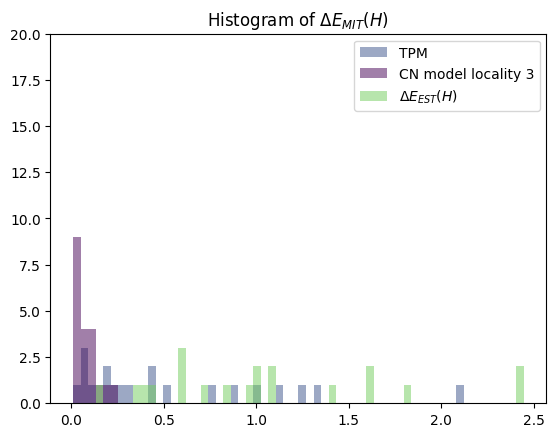

<Figure size 640x480 with 0 Axes>

In [12]:

benchmark_plots_functions.create_error_mitigation_histogram(mitigation_data=mitigation_data,energy_dictionary=energy_dictionary,number_of_qubits=number_of_qubits)